In [13]:
import cv2
import numpy as np
import os
import time, random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [14]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TANH_MULTIPLIER = 150.0

class ResidualBlock(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(c, c, 3, padding='same'),
            nn.InstanceNorm2d(c, affine=True, track_running_stats=False),
            nn.ReLU(),
            nn.Conv2d(c, c, 3, padding='same'),
            nn.InstanceNorm2d(c, affine=True, track_running_stats=False),
        )
    def forward(self, x): return x + self.block(x)

class TransformerNetModern(nn.Module):
    def __init__(self, tanh_multiplier=180.0):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 9, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.resblocks = nn.Sequential(*[ResidualBlock(128) for _ in range(5)])
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, 9, stride=1, padding='same'),
            nn.Tanh()
        )
        self.tanh_multiplier = tanh_multiplier

    def forward(self, x):
        out = self.decoder(self.resblocks(self.encoder(x))) * self.tanh_multiplier
        return out

device = torch.device(DEVICE)

def transfer(CONTENT_PATH, WEIGHTS_PATH, OUTPUT_PATH):
    
    model = TransformerNetModern(TANH_MULTIPLIER).to(device).eval()
    model.load_state_dict(torch.load(WEIGHTS_PATH, map_location="cpu"))
    # ---- Read image ----
    bgr = cv2.imread(CONTENT_PATH)
    x = torch.from_numpy(bgr.transpose(2,0,1)).float().unsqueeze(0).to(device)
    
    # ---- Infer ----
    with torch.inference_mode():
        y = model(x)
    out = y.squeeze().cpu().numpy().transpose(1,2,0)
    out = np.clip(out, 0, 255).astype(np.uint8)
    
    # ---- Save & Show (convert to RGB for display) ----
    cv2.imwrite(OUTPUT_PATH, out)
    print("Saved:", OUTPUT_PATH)
    
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    plt.title("Input")
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
    plt.title("Styled (RGB)")
    plt.axis("off")
    plt.show

In [15]:
def all_imgs(CONTENT_ROOT, WEIGHTS_PATH, OUTPUT_PATH):
    for filename in os.listdir(CONTENT_ROOT):
        if filename.lower().endswith(('.jpg','.png')):
            full_path = os.path.join(CONTENT_ROOT, filename)
            transfer(full_path, WEIGHTS_PATH, OUTPUT_PATH)

CONTENT_PATH = "/kaggle/input/test-style-transfer-1"
WEIGHTS_PATH = "/kaggle/input/mosaic-style/pytorch/default/1/transformer_weight.pth"
OUTPUT_PATH  = "/kaggle/working/styled.png"

all_imgs(CONTENT_PATH, WEIGHTS_PATH, OUTPUT_PATH)

Saved: /kaggle/working/styled.png
Saved: /kaggle/working/styled.png
Saved: /kaggle/working/styled.png
Saved: /kaggle/working/styled.png


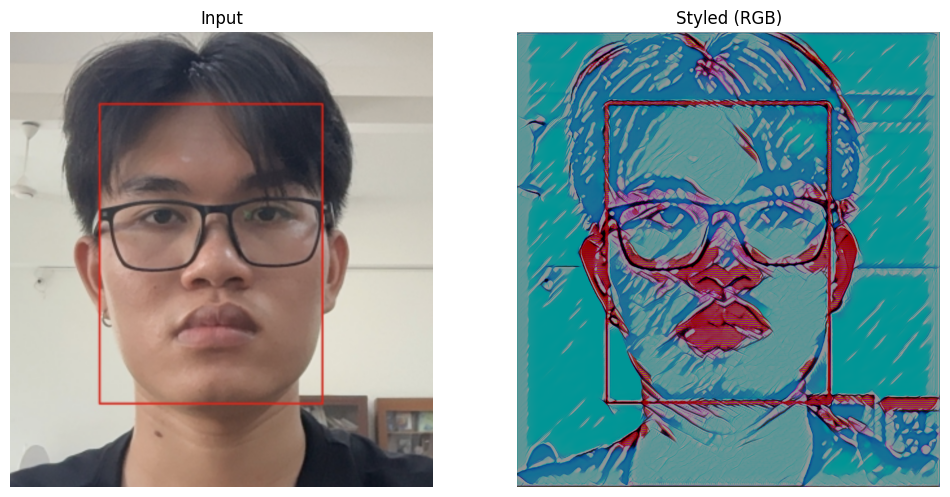

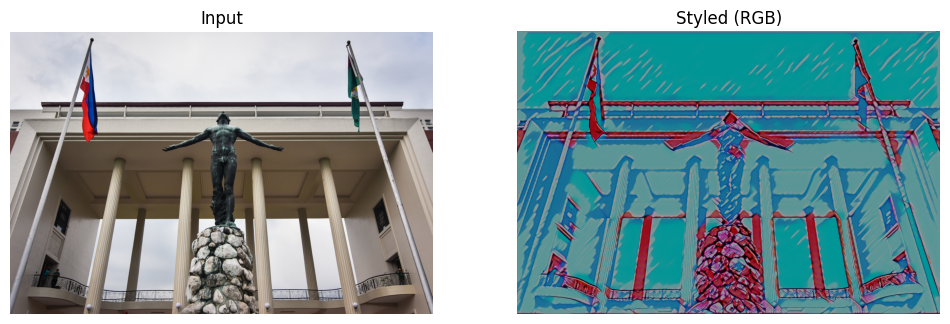

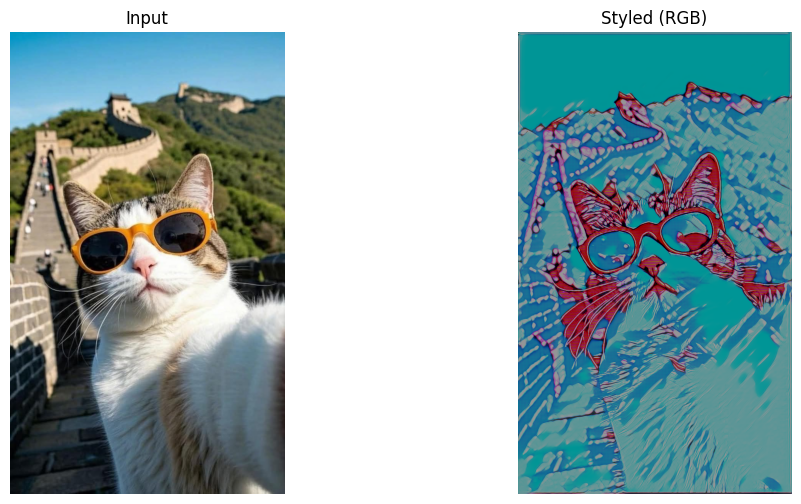

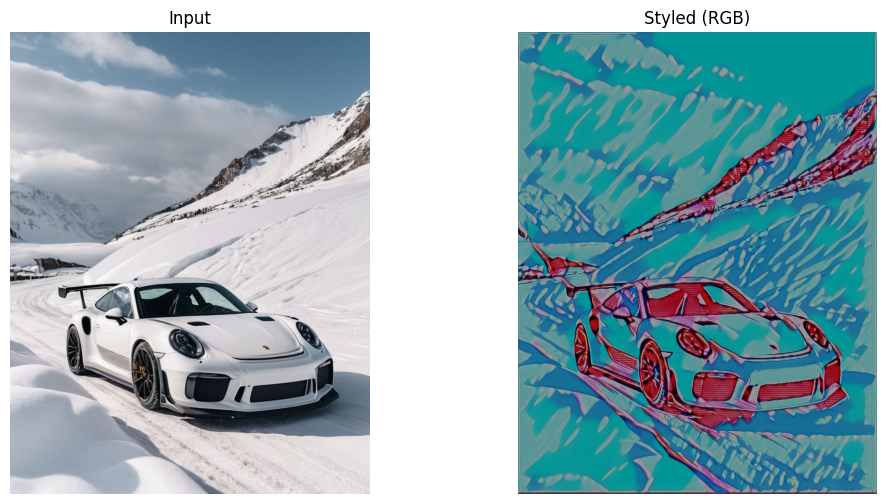

In [17]:
CONTENT_PATH = "/kaggle/input/test-style-transfer-1"
WEIGHTS_PATH = "/kaggle/input/ironman-style/pytorch/default/1/transformer_weight.pth"
OUTPUT_PATH  = "/kaggle/working/styled.png"

all_imgs(CONTENT_PATH, WEIGHTS_PATH, OUTPUT_PATH)

Saved: /kaggle/working/styled.png
Saved: /kaggle/working/styled.png
Saved: /kaggle/working/styled.png
Saved: /kaggle/working/styled.png


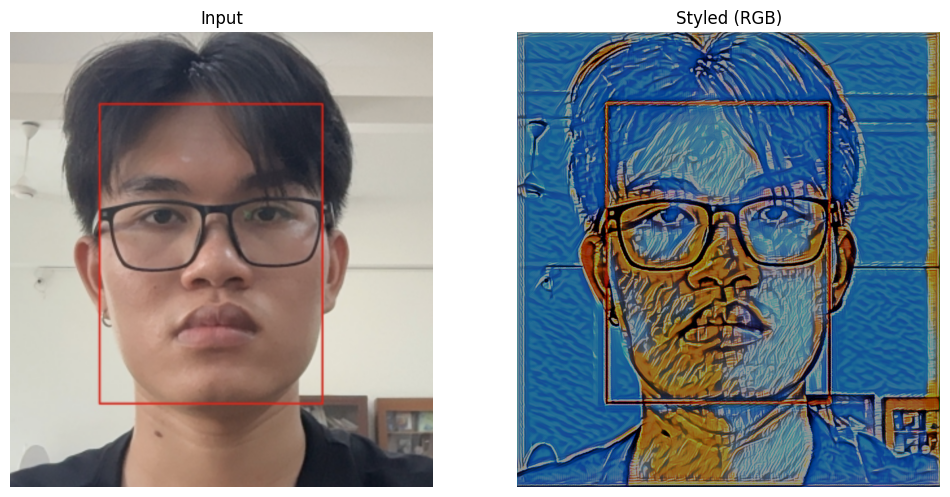

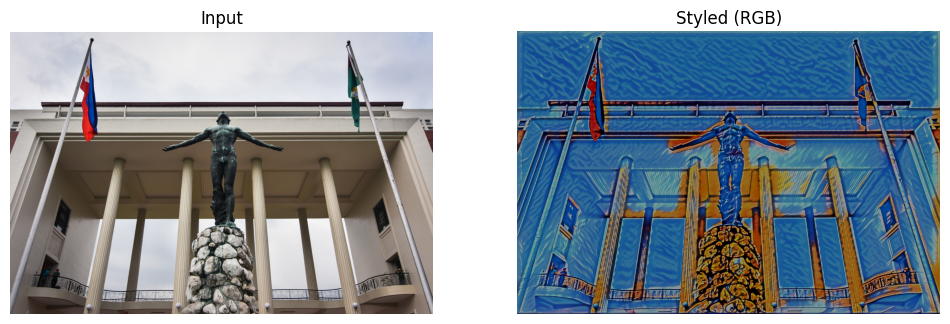

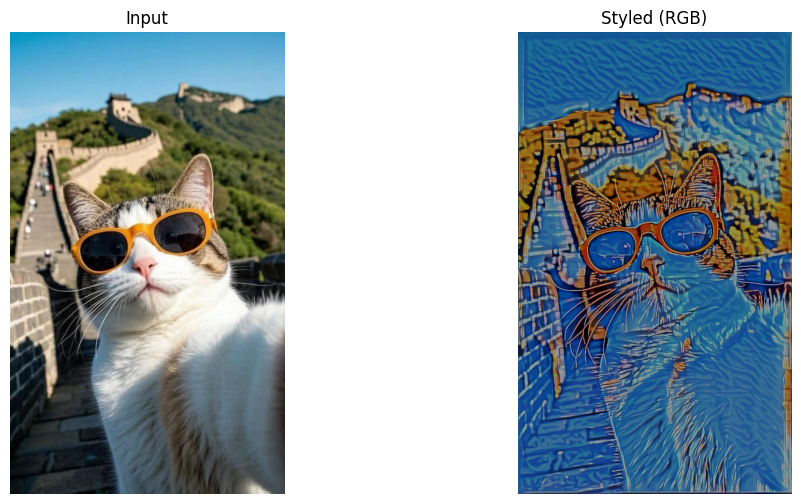

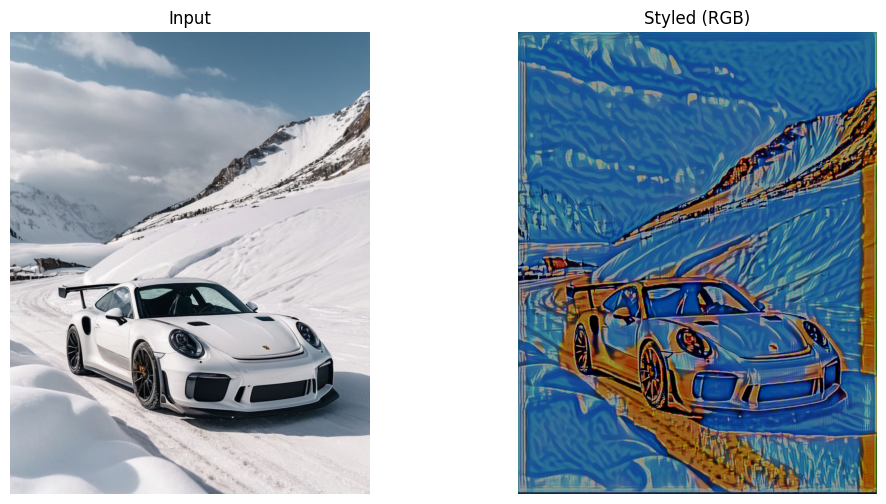

In [18]:
CONTENT_PATH = "/kaggle/input/test-style-transfer-1"
WEIGHTS_PATH = "/kaggle/input/vangoh-castle-style/pytorch/default/1/transformer_weight.pth"
OUTPUT_PATH  = "/kaggle/working/styled.png"

all_imgs(CONTENT_PATH, WEIGHTS_PATH, OUTPUT_PATH)